# Team as an entity model (Varying N)

This model is a

In [1]:
# Import
from torch import nn
from torch.utils.data import DataLoader, random_split

from models.models import *
from datasets.datasets import *
from utils import *

In [2]:
# Meta
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset

In [3]:
file = './Data/team/processed/team_data.xlsx'
dataset = get_team_dataset(file, NL=[2,3,4,5])

Targets
['W%', 'L%']
Normalizing features
[]
All features
['W%', 'L%', 'GF/G', 'GA/G', 'PIM/G', 'oPIM/G', 'S%', 'SV%']
Loading player data
creating dataset structure


Dataset size: (973, 10)
Feature: W%
Feature: L%


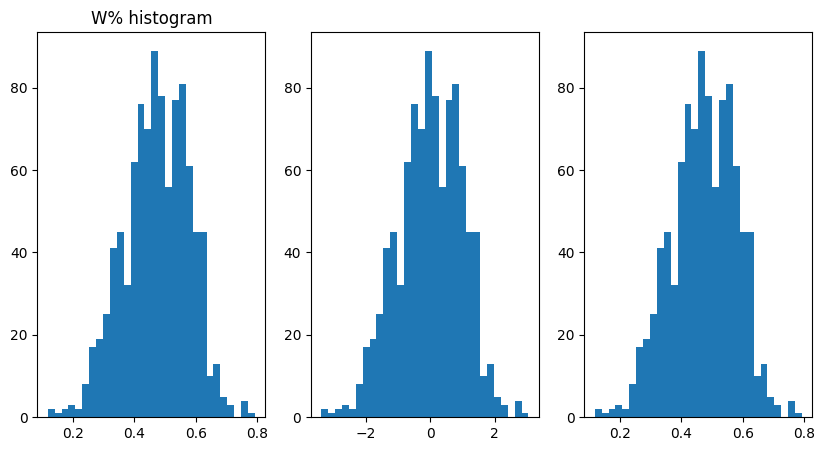

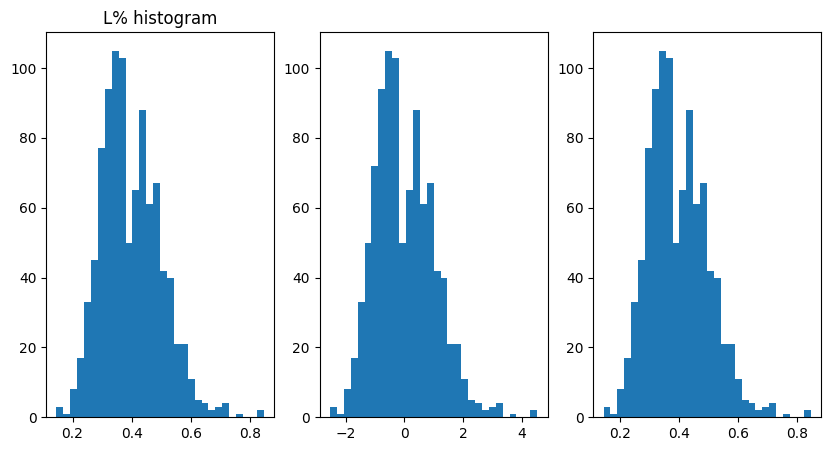

In [4]:
raw_dataset = dataset.alldata
raw_dataset_normalized = dataset.all_data_normalized

print(f"Dataset size: {raw_dataset.shape}")

for feature_name in dataset.col_names:
    if feature_name in dataset.targets:
        print(f"Feature: {feature_name}")
        feature = raw_dataset.loc[:, feature_name]
        feature_normalized = raw_dataset_normalized.loc[:, feature_name]
        features_unnormalized = dataset.unnormalize(torch.tensor(feature_normalized.values), feature_name)
        
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 3, 1)
        plt.hist(feature, bins=30)
        plt.title(f"{feature_name} histogram")
        plt.subplot(1, 3, 2)
        plt.hist(feature_normalized, bins=30)
        plt.subplot(1, 3, 3)
        plt.hist(features_unnormalized, bins=30)

In [5]:
print(raw_dataset)
print(raw_dataset_normalized)

                 team name        W%        L%  GF/G  GA/G  PIM/G  oPIM/G  \
0            Boston Bruins  0.575000  0.312500  3.61  2.90   18.2    19.8   
1           Calgary Flames  0.525000  0.287500  4.35  3.31   21.9    20.3   
2           Buffalo Sabres  0.562500  0.337500  3.58  3.10   18.1    19.0   
3       Montreal Canadiens  0.512500  0.350000  3.60  2.93   19.9    20.7   
4          Edmonton Oilers  0.475000  0.350000  3.94  3.54   25.6    25.7   
..                     ...       ...       ...   ...   ...    ...     ...   
968        Ottawa Senators  0.412698  0.523810  3.17  3.51   10.9    11.6   
969  Columbus Blue Jackets  0.338462  0.507692  2.92  3.60    8.2     8.2   
970          Anaheim Ducks  0.353846  0.600000  2.58  3.62   14.3    11.9   
971     Chicago Blackhawks  0.272727  0.651515  2.18  3.55    9.0     9.9   
972        San Jose Sharks  0.250000  0.640625  2.19  3.88    9.7     8.2   

       S%    SV%  Season  
0    11.1  0.892    1990  
1    12.7  0.869    1

# Dataloader

In [6]:
batch_size = 100

# NOTE: we avoid contamination by training/testing with different players/teams
N_datasets = dataset.random_split(0.1)

dataloaders_train = {}
dataloaders_test ={}
for Nd in N_datasets:
    dataset_train = TeamDataset(Nd[1],N=Nd[0])
    dataset_test = TeamDataset(Nd[2],N=Nd[0])

    # Must generate batches of sequence data with the following format:
    # (batch_size, num_seasons(N), input_size(num stats))
    # (https://stackoverflow.com/questions/49466894/how-to-correctly-give-inputs-to-embedding-lstm-and-linear-layers-in-pytorch/49473068#49473068)
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

    dataloaders_train[Nd[0]] = dataloader_train
    dataloaders_test[Nd[0]] = dataloader_test

print(dataset_train.__getitem__(0))

(tensor([[-1.1842,  0.7862,  1.6251,  2.5146,  2.5103,  2.1259,  2.4398, -2.7366],
        [-0.4674,  0.7862,  1.1839,  1.8306,  2.0257,  1.6513,  1.7000, -2.4857],
        [ 0.6078, -0.8510,  2.5539,  0.6613,  2.2777,  1.9875,  2.6042, -1.3983],
        [ 0.8183, -0.6411,  3.4595,  0.9481,  1.5023,  1.6315,  2.9330, -1.4820],
        [ 0.7046, -0.4012,  3.1112,  0.8157,  1.3666,  1.5722,  1.7822, -1.8166]]), tensor([ 2.0414, -1.6906]))


# Models

In [7]:
input_size = len(dataset_train.__getitem__(0)[0][0])
output_size = len(dataset_train.__getitem__(0)[1])
hidden_size = 50
#model = TeamAsEntity(input_size=input_size, hidden_size=hidden_size, device=device).to(device)

"""
Hidden Layers Size Exploration
"""
#hidden_sizes = [5, 10, 20]
hidden_sizes = [5]


"""
Stacked LSTM Exploration
"""
#num_layerss = [1,2,3]
num_layerss = [1]

# Training and Validation

In [8]:
criterion = RMSELoss()
opt = torch.optim.Adam
epochs = 1000
loss_interval = 25

In [9]:
results = []

for hidden_size in hidden_sizes:
    for num_layers in num_layerss:

        print("\n####################")
        print(f"Model: {hidden_size}_{num_layers}")
        print("####################\n")

        model = TeamStandalone(input_size=input_size, output_size=output_size, hidden_size=hidden_size, num_layers=num_layers, device=device).to(device)
        optimizer = opt(model.parameters(),lr=0.0001)
        
        res = train_and_validate_varying_N(model, criterion, optimizer, dataloaders_train, dataloaders_test, epochs=epochs, loss_interval=loss_interval, device=device)
        results.append([(hidden_size,num_layers), res])


####################
Model: 5_1
####################



0 th epoch :  1.0271040797233582
Validation loss for epoch 0: 0.8974108099937439
Validation loss for epoch 25: 0.888676255941391
50 th epoch :  1.0020457357168198
Validation loss for epoch 50: 0.8810946196317673
Validation loss for epoch 75: 0.8739170283079147
100 th epoch :  1.0096914768218994
Validation loss for epoch 100: 0.8682516515254974
Validation loss for epoch 125: 0.8621779829263687
150 th epoch :  0.9634779840707779
Validation loss for epoch 150: 0.8545702546834946
Validation loss for epoch 175: 0.8449561595916748
200 th epoch :  0.9049338400363922
Validation loss for epoch 200: 0.833245262503624
Validation loss for epoch 225: 0.8195533603429794
250 th epoch :  0.8676750659942627
Validation loss for epoch 250: 0.8051869124174118
Validation loss for epoch 275: 0.7904999852180481
300 th epoch :  0.8888494372367859
Validation loss for epoch 300: 0.7771506756544113
Validation loss for epoch 325: 0.7678527384996414
350 th epoch :  0.8141350150108337
Validation loss for epoch 350:

# Plot Results

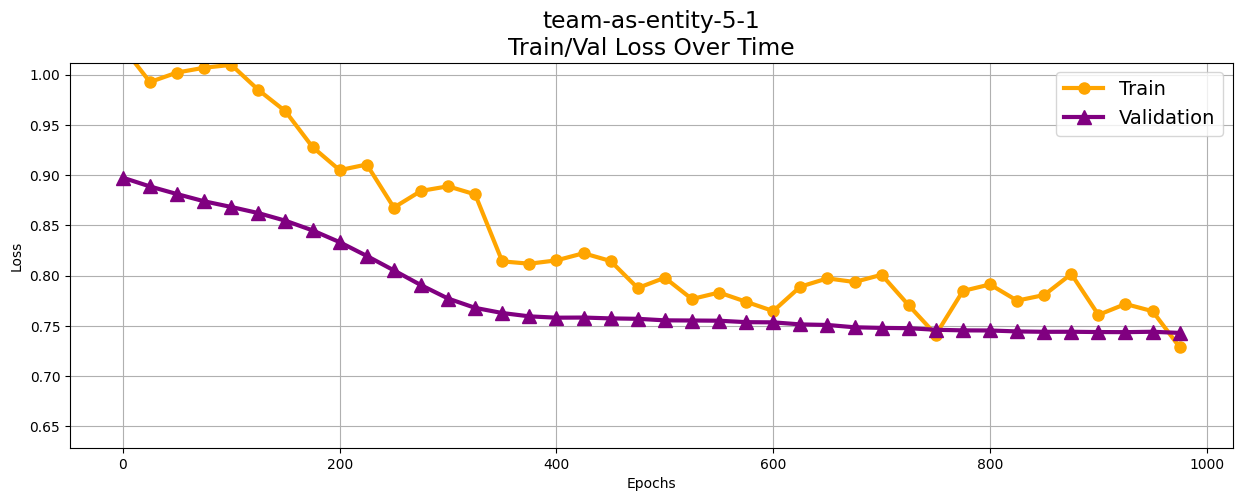

In [10]:
for res in  results:
    plot_train_v_loss(f"team-as-entity-{res[0][0]}-{res[0][1]}", res[1][1], res[1][2], loss_interval)

# Exploration results

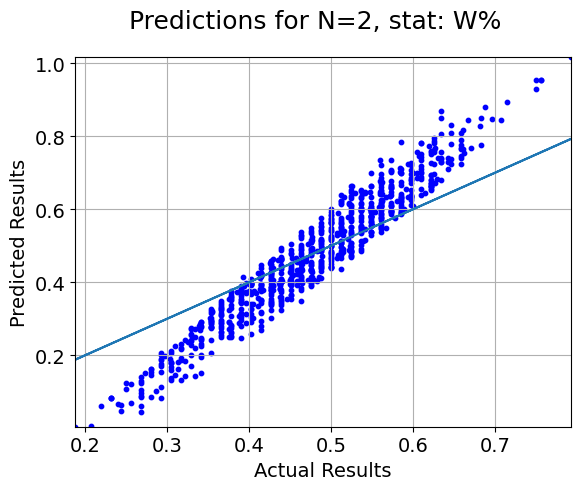

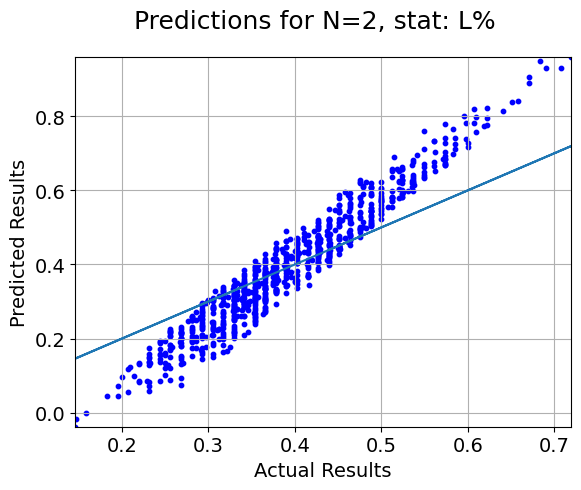

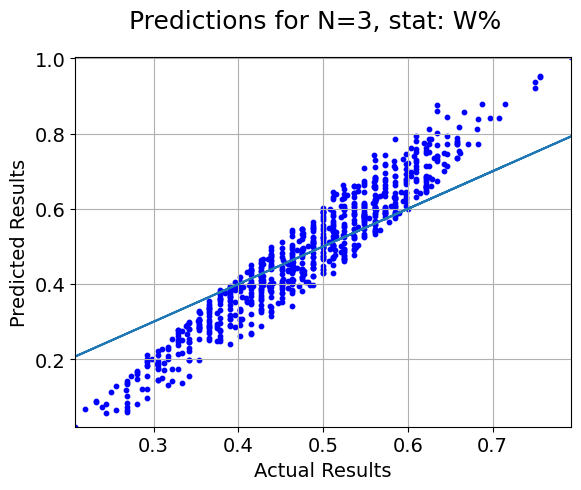

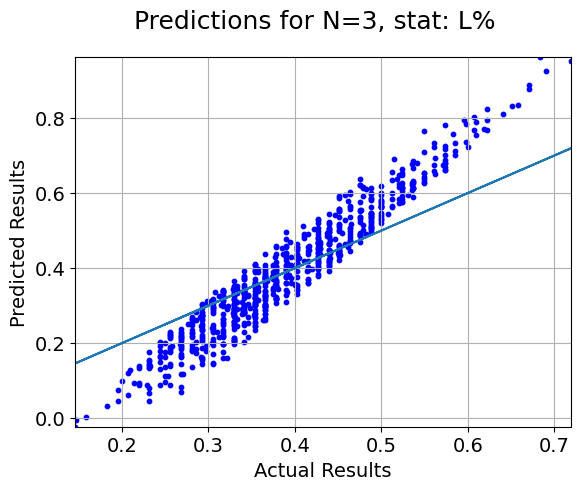

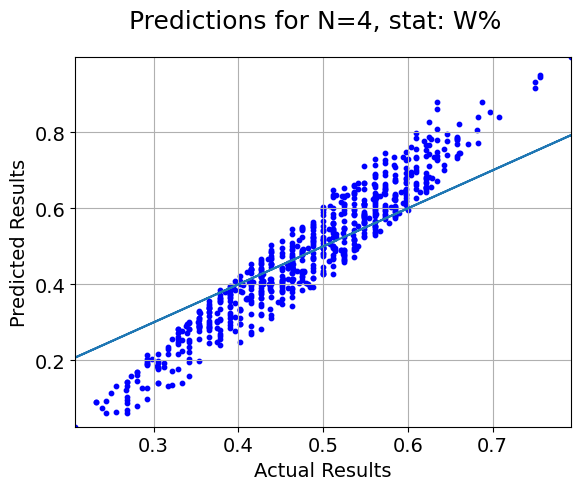

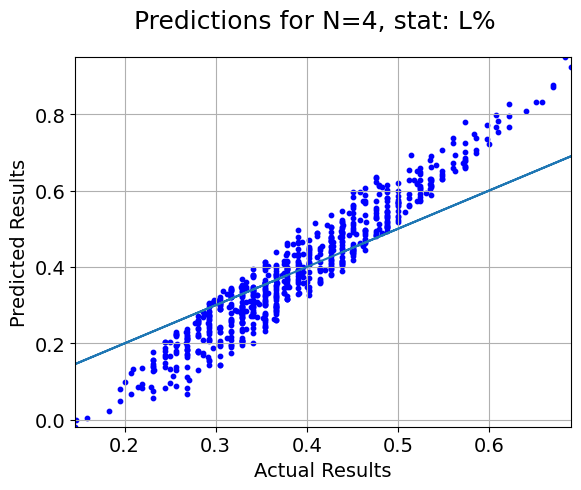

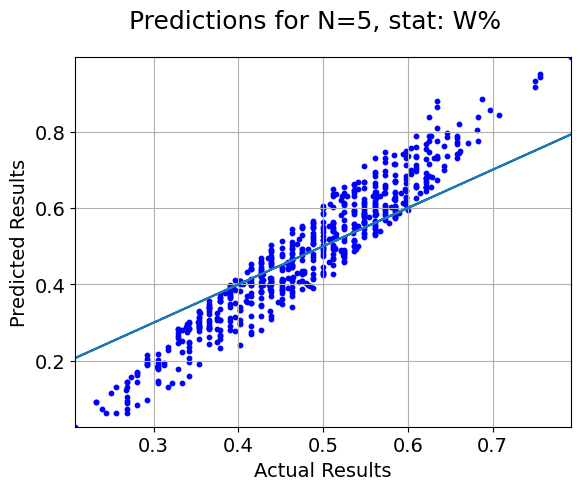

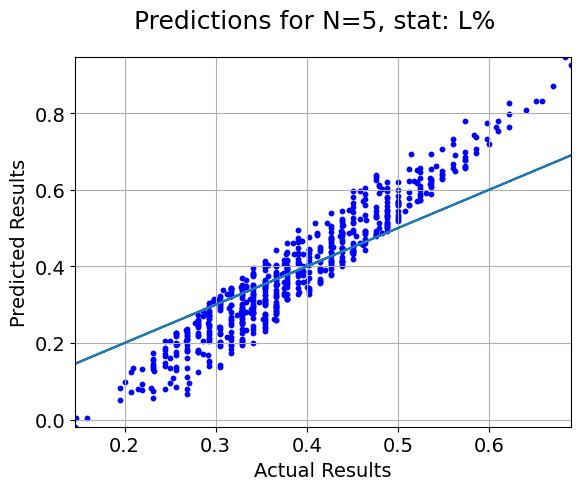

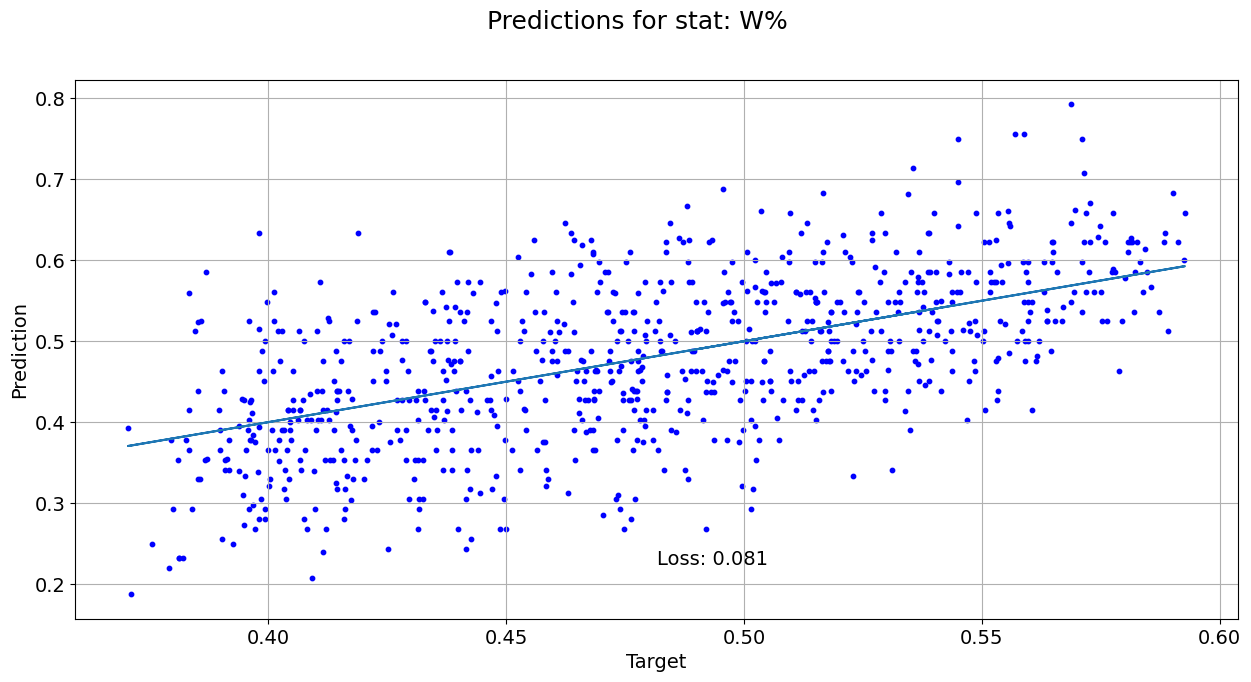

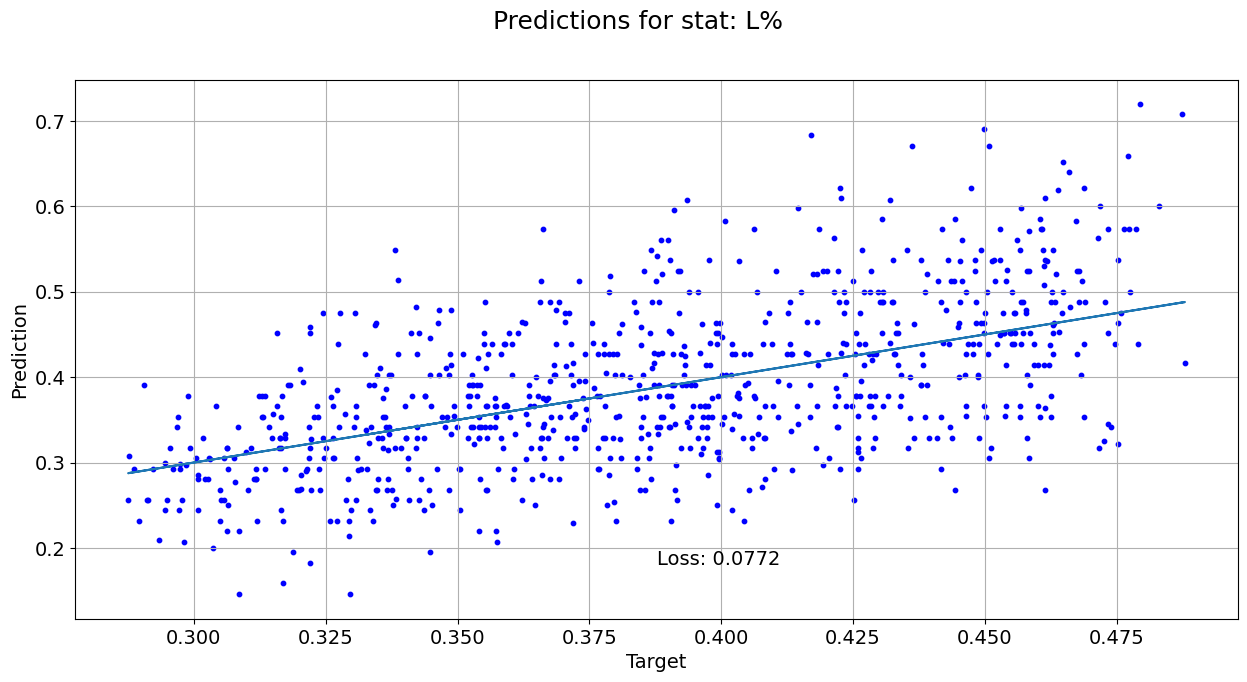

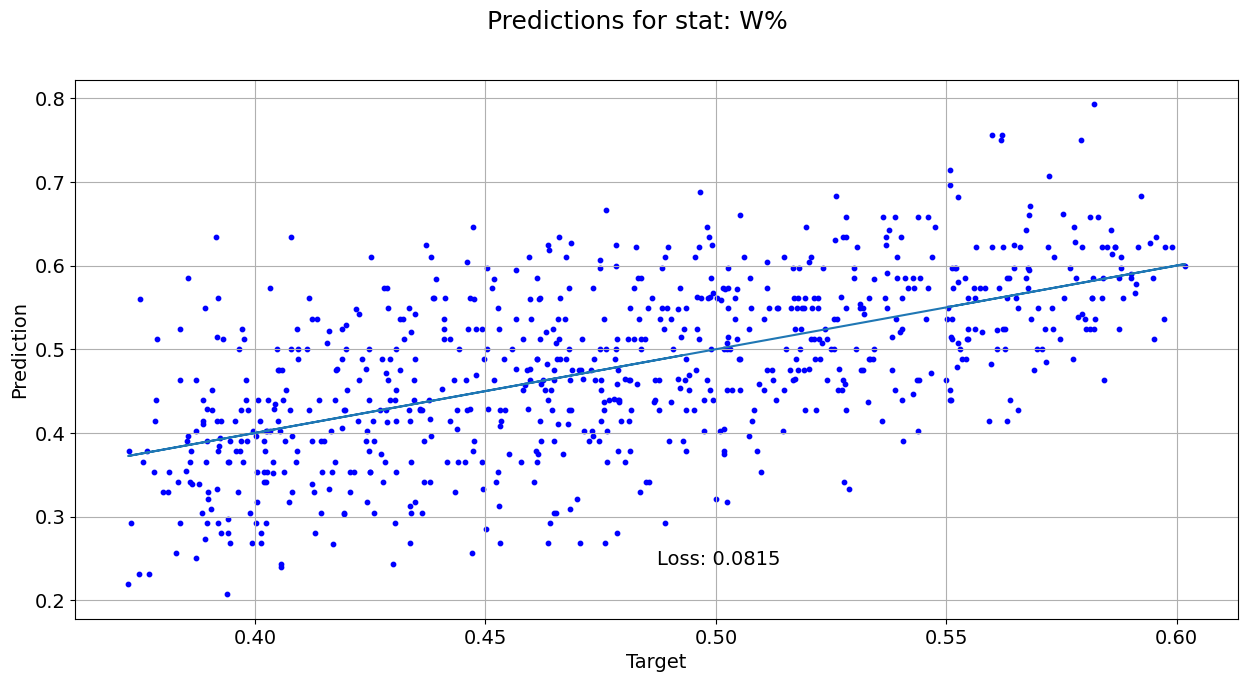

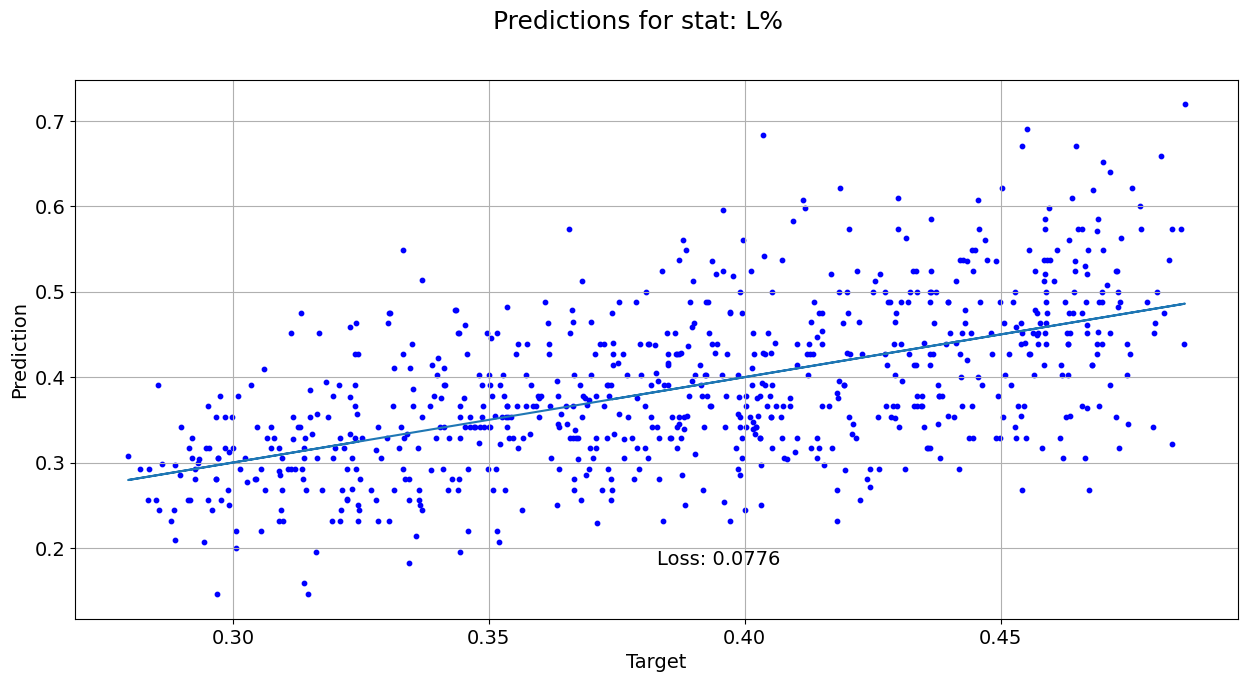

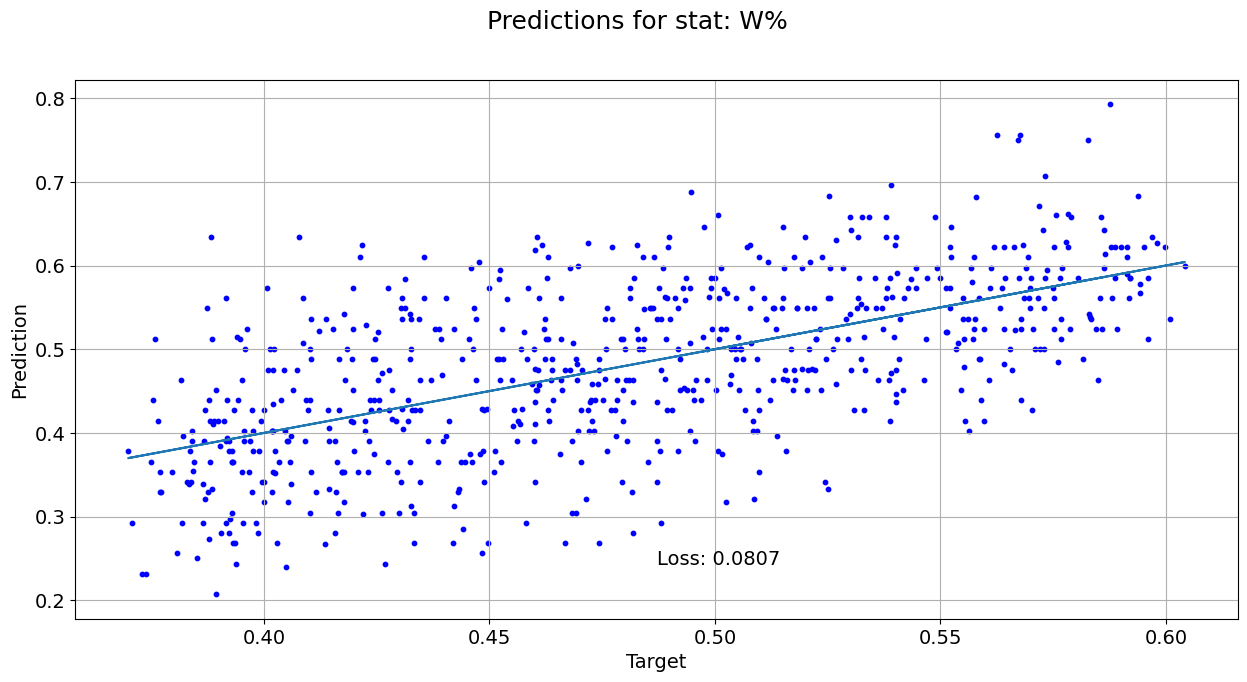

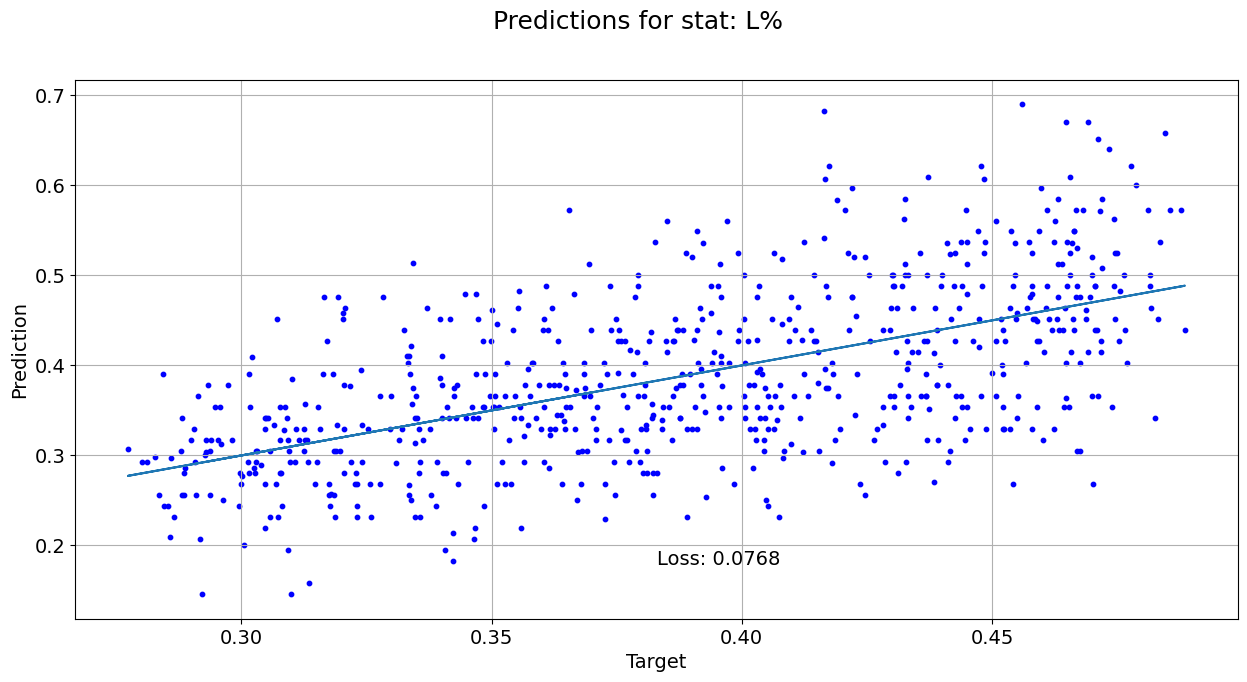

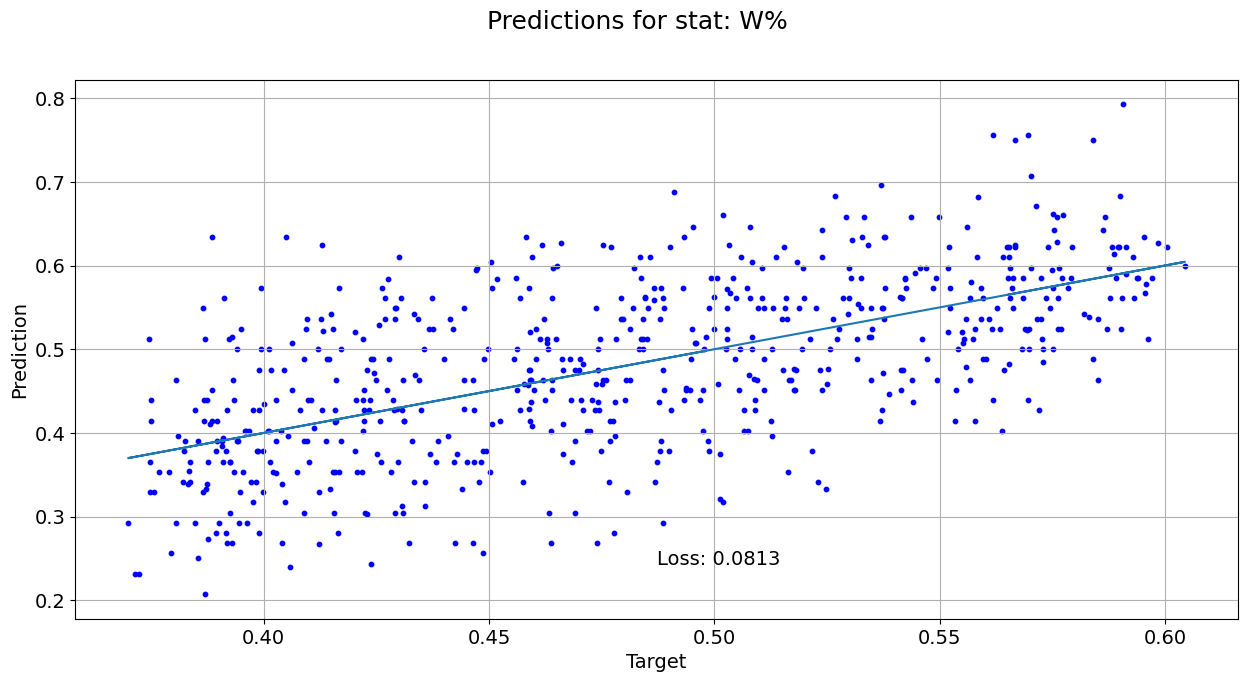

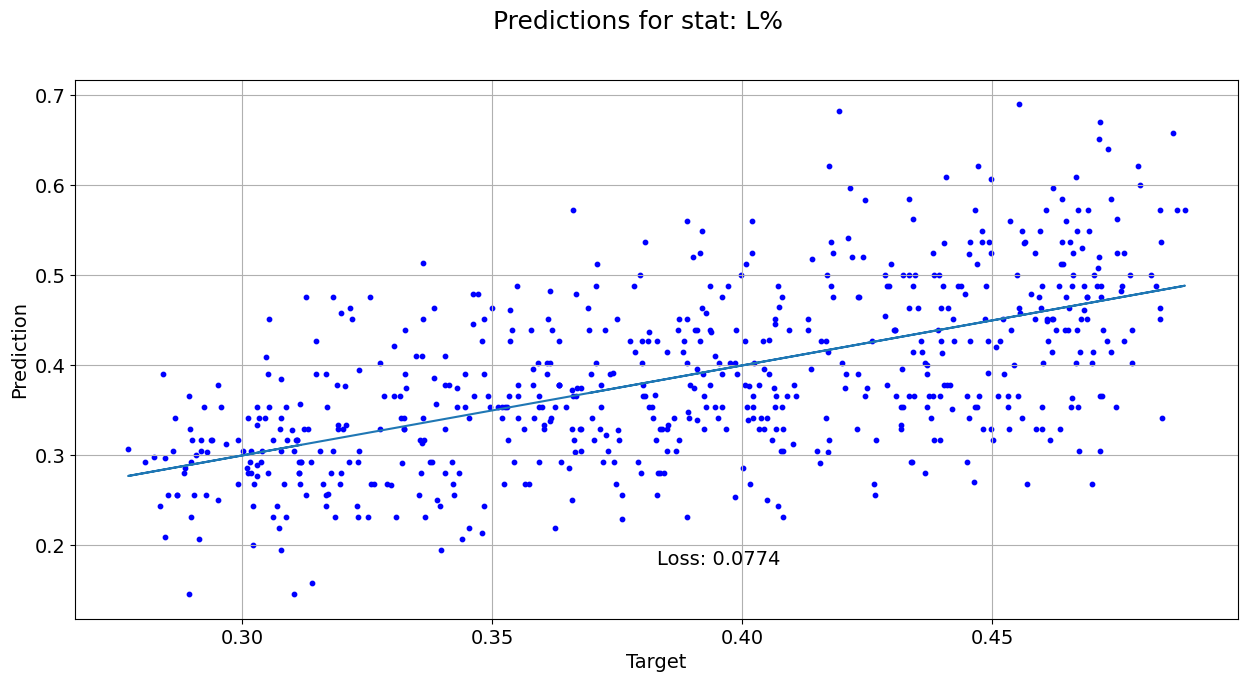

In [11]:
preds_n_targets = get_targets_preds_pairs(dataset, model, device)

#unnormalize
for pair in preds_n_targets:
    target = dataset.unnormalize(preds_n_targets[pair][0]) 
    pred = dataset.unnormalize(preds_n_targets[pair][1])
    preds_n_targets[pair] = (target, pred)
    
plot_divergence(dataset.NL, preds_n_targets, criterion, dataset.col_names)
plot_correlation(dataset.NL, preds_n_targets, criterion, dataset.col_names)